In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

%matplotlib inline

In [2]:
make_moons?

Signature: make_moons(n_samples=100, shuffle=True, noise=None, random_state=None)
Docstring:
Make two interleaving half circles

A simple toy dataset to visualize clustering and classification
algorithms. Read more in the :ref:`User Guide <sample_generators>`.

Parameters
----------
n_samples : int, optional (default=100)
    The total number of points generated.

shuffle : bool, optional (default=True)
    Whether to shuffle the samples.

noise : double or None (default=None)
    Standard deviation of Gaussian noise added to the data.

random_state : int, RandomState instance or None (default)
    Determines random number generation for dataset shuffling and noise.
    Pass an int for reproducible output across multiple function calls.
    See :term:`Glossary <random_state>`.

Returns
-------
X : array of shape [n_samples, 2]
    The generated samples.

y : array of shape [n_samples]
    The integer labels (0 or 1) for class membership of each sample.
File:      ~/.local/lib/python3.7

In [3]:
X_train, y_train = make_moons(300, noise=.2)

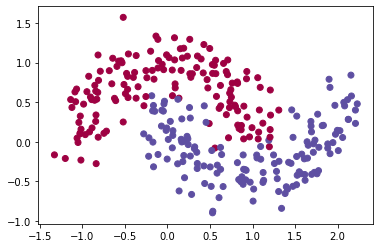

In [4]:
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.Spectral)

In [5]:
class Layer:
    def __init__(self, n_input_dims, n_neurons, activation=None, weights=None, bias=None):
        self.weights = weights if weights is not None else np.random.randn(
            n_input_dims, n_neurons) * np.sqrt(2 / n_input_dims)
        self.bias = bias if bias is not None else np.zeros(n_neurons)
        self.activation = activation
        self.A = None
        self.dA = None
        self.dZ = None
        self.dW = None
        self.db = None
        self.vdW = np.zeros_like(self.weights)
        self.vdb = np.zeros_like(self.bias)
        self.sdW = np.zeros_like(self.weights)
        self.sdb = np.zeros_like(self.bias)

    def activate(self, X):
        Z = np.dot(X, self.weights) + self.bias
        # 激活函数的输出
        self.A = self._apply_activation(Z)
        return self.A
    
    def _apply_activation(self, Z):
        # 激活函数
        if self.activation is None:
            return Z
        elif self.activation == 'relu':
            return np.maximum(0, Z)
        elif self.activation == 'sigmoid':
            return 1 / (1 + np.exp(-Z))
        elif self.activation == 'tanh':
            return np.tanh(Z)
        else:
            return Z
    
    def derivative(self, A):
        # 激活函数的导数
        if self.activation is None:
            return np.ones_like(A)
        elif self.activation == 'relu':
            # return np.where(A <= 0, 0., 1.)
            d = np.array(A, copy=True)
            d[A <= 0] = 0.
            d[A > 0] = 1.
            return d 
        elif self.activation == 'sigmoid':
            return A  * (1 - A)
        elif self.activation == 'tanh':
            return 1 - A ** 2
        else:
            return A
    
    def __repr__(self):
        return f"weigths: {self.weights.shape}\n bias: {self.bias.shape}"

In [6]:
class DeepNeuralNetwork:
    def __init__(self, lambda_=1e-3, lr=1e-3, max_epochs=10000, 
                 batch_size=64, optimizer='Adam', beta1=0.9,
                 beta2=0.999, epsilon=1e-8, verbose=1, random_state=0):
        self.layers = []
        self.lr = lr
        self.lambda_ = lambda_
        self.max_epochs = max_epochs
        self.batch_size = batch_size
        self.optimizer = optimizer
        self.beta1 = beta1
        self.beta2 = beta2
        self.verbose = verbose
        self.epsilon = epsilon
        self.seed = random_state
    
    def add_layer(self, layer):
        self.layers.append(layer)
    
    def feed_forward(self, X):
        for layer in self.layers:
            X = layer.activate(X)
        return X

    def loss(self, y_true, y_preds):
        # 交叉熵误差
        assert(y_true.shape == y_preds.shape)
        term = 0
        for layer in self.layers:
            term += np.sum(layer.weights ** 2)
        loss_ = - y_true* np.log(y_preds + self.epsilon) - (1 - y_true)*np.log(1 - y_preds + self.epsilon)  
        loss_ =  np.mean(loss_, axis=0) + self.lambda_ * term

        return np.squeeze(loss_)
    
    def backpropagation(self, X, y, t):
        # 反向传播算法 计算每一层的dW, db
        # 前向计算 得到输出值
        m = X.shape[0]  # batch size
        self.feed_forward(X)  # (m, 1)
        # print(out.shape)
        # loss_ = self.loss(y, out)
        for i in reversed(range(len(self.layers))):  # 从最后一层开始
            layer = self.layers[i]
            o_i = X if i == 0 else self.layers[i-1].A
            if layer == self.layers[-1]:  # 输出层
                # 使用 交叉熵 误差
                assert(y.shape == layer.A.shape)
                layer.dA = -y/(layer.A + self.epsilon) + (1-y) / (1-layer.A + self.epsilon)
                # layer.dA = -y / out + (1-y)/(1-out)  # dL/dA^K  # (m, 1)
            else:  # 隐藏层
                next_layer = self.layers[i + 1]
                layer.dA = next_layer.dZ @ next_layer.weights.T  # dL/dA^J (m, 1) (1, k)
                # dL/dZ^J (m, k) (m,k)
            layer.dZ = layer.dA * layer.derivative(layer.A)
            layer.dW =  o_i.T @ layer.dZ * 1 / m
            layer.db = np.sum(layer.dZ) * 1 / m
            w_term = self.lambda_ * layer.weights * 1 / m

            if self.optimizer == 'Momentum':
                layer.vdW = self.beta1 * layer.vdW + (1 - self.beta1) * layer.dW
                layer.vdb = self.beta1 * layer.vdb + (1 - self.beta1) * layer.db
                layer.weights -= self.lr * (layer.vdW + w_term)
                layer.bias -= self.lr * layer.vdb
            elif self.optimizer == 'RMSprop':
                layer.sdW = self.beta2 * layer.sdW + (1 - self.beta2) * layer.dW ** 2
                layer.sdb = self.beta2 * layer.sdb + (1 - self.beta2) * layer.db ** 2  
                layer.weights -= self.lr * (layer.dW / (layer.sdW ** 0.5 + self.epsilon) + w_term)
                layer.bias -= self.lr * layer.db / (layer.sdb ** 0.5 + self.epsilon)
            elif self.optimizer == 'Adam':
                layer.vdW = self.beta1 * layer.vdW + (1 - self.beta1) * layer.dW
                layer.vdb = self.beta1 * layer.vdb + (1 - self.beta1) * layer.db
                # layer.vdW = vdW / (1 - self.beta1 ** t)
                # layer.vdb = vdb / (1 - self.beta1 ** t)
    
                layer.sdW = self.beta2 * layer.sdW + (1 - self.beta2) * layer.dW ** 2
                layer.sdb = self.beta2 * layer.sdb + (1 - self.beta2) * layer.db ** 2
                # layer.sdW = sdW / (1 - np.power(self.beta2, t))
                # layer.sdb = sdb / (1 -  np.power(self.beta2, t))

                # 改变计算顺序而得到提升效率 防止溢出
                lr = self.lr * (1 - self.beta2 ** t) ** 0.5 / (1 - self.beta1 ** t)
                layer.weights -= lr * layer.vdW / (layer.sdW ** 0.5 + self.epsilon) + self.lr * w_term
                layer.bias -= lr * layer.vdb / (layer.sdb ** 0.5 + self.epsilon)                       
            else:
                layer.weights -= self.lr * (layer.dW + w_term)
                layer.bias -=  self.lr * layer.db
         
    def preprocessing(self, X, y):
        y = y.reshape((-1, 1))
        self.seed += 1
        np.random.seed(self.seed)
        permutation = np.random.permutation(X.shape[0])
        shuffled_X = X[permutation]
        shuffled_y = y[permutation]
        
        return shuffled_X, shuffled_y
    
    def fit(self, X, y):
        y = y.reshape(-1, 1)
        cross_entropy = []
        # accuracy = []
        batch_size = self.batch_size
        m = X.shape[0]
        batches = m // batch_size if m % batch_size == 0 else m // batch_size + 1
        t = 0
        for epoch in range(self.max_epochs):
            # 每个epoch X,y 顺序都不一样
            
            shuffled_X, shuffled_y = self.preprocessing(X, y)
            # print(self.seed)
            for step in range(batches):
                
                batch_X = shuffled_X[batch_size*step: batch_size*(step+1)]
                batch_y = shuffled_y[batch_size*step: batch_size*(step+1)]
                # t 需要从1开始
                t += 1
                self.backpropagation(batch_X, batch_y, t)
            if epoch % 100 == 0:
                loss = self.loss(y, self.feed_forward(X))
                cross_entropy.append(loss)
            if epoch % 1000 == 0 and self.verbose:
#                 predict = self.predict(X_train)
#                 train_acc = np.sum(y_train.ravel()==predict) / len(predict)
                
#                 predict = self.predict(X_test)
#                 acc = np.sum(y_test.ravel()==predict) / len(predict)
#                 accuracy.append(acc)
                print(f'Epoch: {epoch}, cross_entropy: {loss}')
        return cross_entropy
    
    def predict(self, X):
        y_pred = self.feed_forward(X)
        y_pred = np.where(y_pred >=0.5, 1, 0)
        # out = np.argmax(y_pred, axis=1)
        return np.squeeze(y_pred)

In [7]:
def plot_decision(model, X, y):
    x_max = X[:, 0].max() + 1
    x_min = X[:, 0].min() - 1
    y_max = X[:, 1].max() + 1
    y_min = X[:, 1].min() - 1
    xx, yy = np.mgrid[x_min:x_max:0.01, y_min:y_max:0.01]
    zz = np.c_[xx.ravel(), yy.ravel()]
    preds = model.predict(zz)
    plt.contourf(xx, yy, preds.reshape(xx.shape), cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[:, 0], X[:, 1], c=np.squeeze(y), cmap=plt.cm.Spectral)
    plt.show()

### Mini-batch Gradient descent

In [20]:
model_1 = DeepNeuralNetwork(lambda_=0, lr=0.0007, max_epochs=10000, optimizer='gd')
model_1.add_layer(Layer(X_train.shape[1], 5, activation='relu'))
model_1.add_layer(Layer(5, 2, activation='relu'))
model_1.add_layer(Layer(2, 1, activation='sigmoid'))

cross_entropy = model_1.fit(X_train, y_train)
preds = model_1.predict(X_train)
np.mean(preds == y_train)

Epoch: 0, cross_entropy: 0.7728034900977689
Epoch: 1000, cross_entropy: 0.5147491184022799
Epoch: 2000, cross_entropy: 0.4846917433139486
Epoch: 3000, cross_entropy: 0.4671700700735236
Epoch: 4000, cross_entropy: 0.45590008170096025
Epoch: 5000, cross_entropy: 0.4470867527468236
Epoch: 6000, cross_entropy: 0.43933138478304157
Epoch: 7000, cross_entropy: 0.4322137086170578
Epoch: 8000, cross_entropy: 0.42578665522890186
Epoch: 9000, cross_entropy: 0.41967958061029254


0.8233333333333334

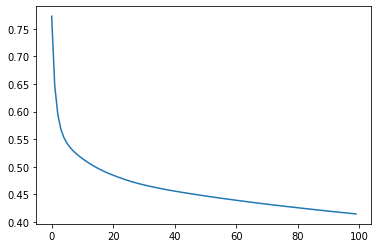

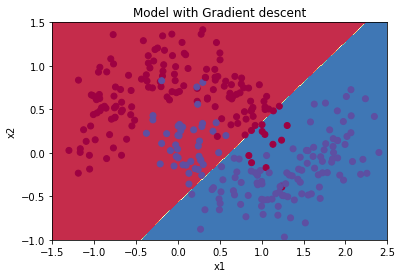

In [21]:
plt.plot(cross_entropy)
plt.show()
plt.title("Model with Gradient descent")

axes = plt.gca()
axes.set_xlim([-1.5, 2.5])
axes.set_ylim([-1, 1.5])
plot_decision(model_1, X_train, y_train)

### Mini-batch with Momentum mode

In [22]:
model_2 = DeepNeuralNetwork(lambda_=0, lr=0.0007, max_epochs=10000, optimizer='Momentum')
model_2.add_layer(Layer(X_train.shape[1], 5, activation='relu'))
model_2.add_layer(Layer(5, 2, activation='relu'))
model_2.add_layer(Layer(2, 1, activation='sigmoid'))

cross_entropy = model_2.fit(X_train, y_train)
preds = model_2.predict(X_train)
np.mean(preds == y_train)

Epoch: 0, cross_entropy: 0.7742290759378947
Epoch: 1000, cross_entropy: 0.5147815265266582
Epoch: 2000, cross_entropy: 0.4847043325839786
Epoch: 3000, cross_entropy: 0.4671784794606152
Epoch: 4000, cross_entropy: 0.4559092484451153
Epoch: 5000, cross_entropy: 0.44710003303401263
Epoch: 6000, cross_entropy: 0.4393451030173272
Epoch: 7000, cross_entropy: 0.4322283430327089
Epoch: 8000, cross_entropy: 0.42580081053770374
Epoch: 9000, cross_entropy: 0.41969917627137504


0.8233333333333334

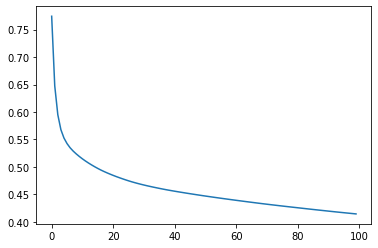

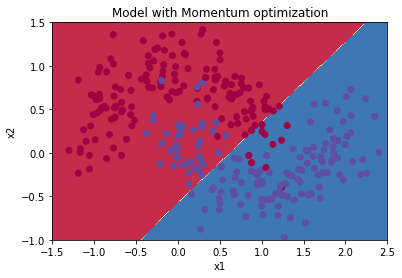

In [23]:
plt.plot(cross_entropy)
plt.show()
plt.title("Model with Momentum optimization")

axes = plt.gca()
axes.set_xlim([-1.5, 2.5])
axes.set_ylim([-1, 1.5])
plot_decision(model_2, X_train, y_train)

### Mini-batch with RMSprop mode


In [13]:
model_3 = DeepNeuralNetwork(lambda_=0, lr=0.0007, max_epochs=10000, optimizer='RMSprop')
model_3.add_layer(Layer(X_train.shape[1], 5, activation='relu'))
model_3.add_layer(Layer(5, 2, activation='relu'))
model_3.add_layer(Layer(2, 1, activation='sigmoid'))

cross_entropy = model_3.fit(X_train, y_train)
preds = model_3.predict(X_train)
np.mean(preds == y_train)

Epoch: 0, cross_entropy: 0.6407643559122855
Epoch: 1000, cross_entropy: 0.14746365188913885
Epoch: 2000, cross_entropy: 0.120577240336543
Epoch: 3000, cross_entropy: 0.11231839485687838
Epoch: 4000, cross_entropy: 0.10819588481295424
Epoch: 5000, cross_entropy: 0.10588986603269947
Epoch: 6000, cross_entropy: 0.1047255046816546
Epoch: 7000, cross_entropy: 0.1040085509114234
Epoch: 8000, cross_entropy: 0.10352404071151672
Epoch: 9000, cross_entropy: 0.10324446949941787
50000


0.9566666666666667

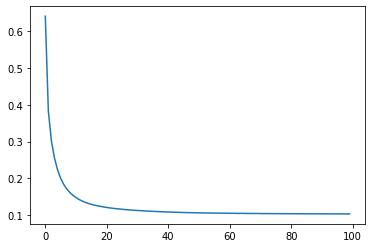

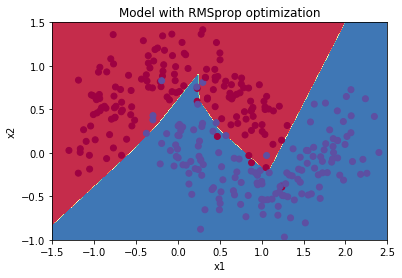

In [14]:
plt.plot(cross_entropy)
plt.show()
plt.title("Model with RMSprop optimization")

axes = plt.gca()
axes.set_xlim([-1.5, 2.5])
axes.set_ylim([-1, 1.5])
plot_decision(model_3, X_train, y_train)

### Mini-batch with Adam mode

In [31]:
t = 1
(1 - 0.999 ** t) ** 0.5 / (1 - 0.9 ** t)

0.3162277660168381

In [24]:
model_4 = DeepNeuralNetwork(lambda_=0, lr=0.0007, max_epochs=10000, optimizer='Adam')
model_4.add_layer(Layer(X_train.shape[1], 5, activation='relu'))
model_4.add_layer(Layer(5, 2, activation='relu'))
model_4.add_layer(Layer(2, 1, activation='sigmoid'))

cross_entropy = model_4.fit(X_train, y_train)
preds = model_4.predict(X_train)
np.mean(preds == y_train)

Epoch: 0, cross_entropy: 0.7662372273715305
Epoch: 1000, cross_entropy: 0.17191825929152027
Epoch: 2000, cross_entropy: 0.12546367551585544
Epoch: 3000, cross_entropy: 0.11470397763751251
Epoch: 4000, cross_entropy: 0.10981674548386375
Epoch: 5000, cross_entropy: 0.10735914337228183
Epoch: 6000, cross_entropy: 0.10595062420836951
Epoch: 7000, cross_entropy: 0.10504297941905327
Epoch: 8000, cross_entropy: 0.1044238732606478
Epoch: 9000, cross_entropy: 0.1040227934571363


0.9566666666666667

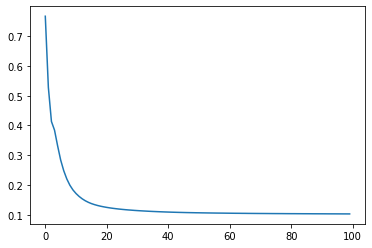

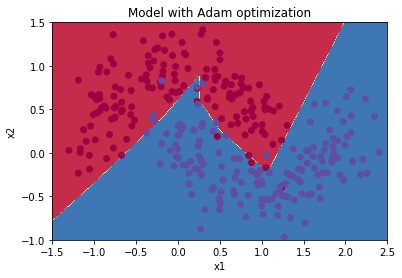

In [26]:
plt.plot(cross_entropy)
plt.show()
plt.title("Model with Adam optimization")

axes = plt.gca()
axes.set_xlim([-1.5, 2.5])
axes.set_ylim([-1, 1.5])
plot_decision(model_4, X_train, y_train)

## 权重衰减

In [8]:
class Network2(DeepNeuralNetwork):
    def __init__(self, lambda_=0.001, lr=0.001, max_epochs=10000, batch_size=64, optimizer='Adam', beta1=0.9, beta2=0.999, epsilon=1e-08, verbose=1, random_state=0, decay_rate=0.5):
        super().__init__(lambda_=lambda_, lr=lr, max_epochs=max_epochs, batch_size=batch_size, optimizer=optimizer, beta1=beta1, beta2=beta2, epsilon=epsilon, verbose=verbose, random_state=random_state)
        self.decay_rate = decay_rate
    def fit(self, X, y):
        y = y.reshape(-1, 1)
        cross_entropy = []
        # accuracy = []
        batch_size = self.batch_size
        m = X.shape[0]
        batches = m // batch_size if m % batch_size == 0 else m // batch_size + 1
        t = 0
        lr = self.lr
        for epoch in range(self.max_epochs):
            # 每个epoch X,y 顺序都不一样
            
            self.lr = lr * (1 / (1 + epoch * self.decay_rate))
            shuffled_X, shuffled_y = self.preprocessing(X, y)
            # print(self.seed)
            for step in range(batches):
                
                batch_X = shuffled_X[batch_size*step: batch_size*(step+1)]
                batch_y = shuffled_y[batch_size*step: batch_size*(step+1)]
                # t 需要从1开始
                t += 1
                self.backpropagation(batch_X, batch_y, t)
            if epoch % 100 == 0:
                loss = self.loss(y, self.feed_forward(X))
                cross_entropy.append(loss)
            if epoch % 1000 == 0 and self.verbose:
#                 predict = self.predict(X_train)
#                 train_acc = np.sum(y_train.ravel()==predict) / len(predict)
                
#                 predict = self.predict(X_test)
#                 acc = np.sum(y_test.ravel()==predict) / len(predict)
#                 accuracy.append(acc)
                print(f'Epoch: {epoch}, cross_entropy: {loss}')
        return cross_entropy
    

In [12]:
model_5 = Network2(lambda_=0, lr=0.0007, max_epochs=10000, optimizer='gd', decay_rate=0.00001)
model_5.add_layer(Layer(X_train.shape[1], 5, activation='relu'))
model_5.add_layer(Layer(5, 2, activation='relu'))
model_5.add_layer(Layer(2, 1, activation='sigmoid'))

cross_entropy = model_5.fit(X_train, y_train)
preds = model_5.predict(X_train)
np.mean(preds == y_train)

Epoch: 0, cross_entropy: 0.7817282618228083
Epoch: 1000, cross_entropy: 0.5205334041832522
Epoch: 2000, cross_entropy: 0.4913824769951992
Epoch: 3000, cross_entropy: 0.473903048387444
Epoch: 4000, cross_entropy: 0.46226331562209416
Epoch: 5000, cross_entropy: 0.4539130362917836
Epoch: 6000, cross_entropy: 0.4470489658404665
Epoch: 7000, cross_entropy: 0.4407612098531776
Epoch: 8000, cross_entropy: 0.4351721349992638
Epoch: 9000, cross_entropy: 0.4297877710444965


0.81